In [58]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

import os
from pydantic import BaseModel,Field
from typing import TypedDict, Literal

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.utilities.wolfram_alpha import WolframAlphaAPIWrapper
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper, OpenWeatherMapAPIWrapper
from langchain.tools import Tool, DuckDuckGoSearchResults, WolframAlphaQueryRun, OpenWeatherMapQueryRun

from langgraph.graph import StateGraph, START, END

from IPython.display import Image, display, Markdown

In [2]:
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ["WOLFRAM_ALPHA_APPID"] = os.getenv("WOLFRAM_ALPHA_APPID")
os.environ["OPENWEATHERMAP_API_KEY"] = os.getenv("WeatherAPI")

In [39]:
class AgentSchema(TypedDict):
    input_message:str
    search_result:str
    query_route:str
    
class AgentSearchRoute(BaseModel):
    search_route : Literal["news", "definitions", "weather", "stocks", "maths"] = Field(..., description="This specifies the category of information the agent should retrieve, such as news updates, word definitions, weather forecasts, stock market data, or shopping results.")

In [41]:
class SearchTools:
    def __init__(self):
        self.llm = ChatOpenAI()
        self.general_wrapper = DuckDuckGoSearchAPIWrapper(region="wt-wt", time="d")
        self.nigeria_news_wrapper = DuckDuckGoSearchAPIWrapper(region="ng-en", time="d")

    def SearchAgent(self, state:AgentSchema):
        valid_sources = {
            "news": ("the latest news updates from Nigeria", self.nigeria_news_wrapper),
            "definitions": ("word definitions from a dictionary", self.general_wrapper),
            "stocks": ("stock market prices and trends", self.general_wrapper),
            "shopping": ("product search results", self.nigeria_news_wrapper)
        }

        description, wrapper = valid_sources[state["query_route"]]
        
        search = DuckDuckGoSearchResults(api_wrapper=wrapper, 
                                         source=state["query_route"])

        search_tool = Tool(name=f"{state['query_route']}_search_tool",
                           func=search.run,
                           handle_tool_error=True,
                           description=f"Use this tool to search for {description}")

        prompt = ChatPromptTemplate.from_messages([
            ("system", f"You are an AI assistant that retrieves {description} and give results based on users query."),
            MessagesPlaceholder("chat_history", optional=True),
            ("user", "{user_input}"),
            MessagesPlaceholder("agent_scratchpad")
        ])

        agent_with_tool = create_tool_calling_agent(llm=self.llm,  
                                                    tools=[search_tool],
                                                    prompt=prompt)

        
        agent_executor = AgentExecutor(name=f"{state['query_route']}_search_agent",
                                       tools=[search_tool],
                                       handle_parsing_errors=True,
                                       agent=agent_with_tool)

        return {"search_result": agent_executor.invoke({"user_input":state["input_message"]})["output"]}

    def GetWeather(self, state:AgentSchema):
        weather_api_wrapper = OpenWeatherMapAPIWrapper()
        weather_query_runner = OpenWeatherMapQueryRun(api_wrapper=weather_api_wrapper)
        weather_query_tool = Tool(name="weather_problem_solver", 
                                  func=weather_query_runner.run, 
                                  description="Use this tool to solve weather-related queries with OpenWeatherMap API.")

        weather_prompt_template = ChatPromptTemplate.from_messages([
            ("system", "You are an AI assistant that provides weather-related information using OpenWeatherMap API."),
            MessagesPlaceholder("chat_history", optional=True),
            ("user", "{user_input}"),
            MessagesPlaceholder("agent_scratchpad")
        ])
        
        weather_agent_with_tools = create_tool_calling_agent(llm=self.llm,  
                                                             # handle_tool_error
                                                             tools=[weather_query_tool],
                                                             prompt=weather_prompt_template)
        
        weather_agent_executor = AgentExecutor(name="weather_agent",
                                               tools=[weather_query_tool],
                                               handle_parsing_errors=True,
                                               agent=weather_agent_with_tools)

        return {"search_result": weather_agent_executor.invoke({"user_input": state["input_message"]})}

    
    def ProblemSolvingAgent(self, state:AgentSchema):
        wolframwrapper = WolframAlphaAPIWrapper()
        
        wolframquery = WolframAlphaQueryRun(api_wrapper=wolframwrapper)
        
        wolframtool = Tool(name="wolfram_problem_solver", 
                           func=wolframquery.run, 
                           description="Use this tool to solve mathematical and scientific problems with Wolfram Alpha.")

        prompt = ChatPromptTemplate.from_messages([
            ("system", "You are an AI assistant that solves mathematical and scientific problems using Wolfram Alpha."),
            MessagesPlaceholder("chat_history", optional=True),
            ("user", "{user_input}"),
            MessagesPlaceholder("agent_scratchpad")
        ])
        
        agent_with_tool = create_tool_calling_agent(llm=self.llm,  
                                                    tools=[wolframtool],
                                                    prompt=prompt)
        
        agent_executor = AgentExecutor(name="problem_solving_agent",
                                       tools=[wolframtool],
                                       handle_parsing_errors=True,
                                       agent=agent_with_tool)

        return {"search_result": agent_executor.invoke({"user_input":state["input_message"]})}

    def GetSearchRoute(self, state:AgentSchema):
        llm_with_structured_output = self.llm.with_structured_output(AgentSearchRoute)

        prompt = ChatPromptTemplate.from_messages([
            ("system", "You are an intelligent agent that categorizes user queries into predefined search routes."),
            ("user", "{user_input}")
        ])

        route_chain = prompt | llm_with_structured_output

        return {"query_route":route_chain.invoke({"user_input":state["input_message"]}).search_route}

    def NodeCondition(self, state:AgentSchema):
        valid_routes = ["news", "definitions", "weather", "stocks", "shopping"]
        
        if state["query_route"] in valid_routes:
            return state["query_route"]
        else:
            return "maths"

In [43]:
search_tool = SearchTools()

In [44]:
# search_tool.GetWeather(state={"input_message":"Current weather in benin today?"})

In [49]:
bot_workflow = StateGraph(AgentSchema)

bot_workflow.add_node("SearchAgent", search_tool.SearchAgent)
bot_workflow.add_node("ProblemSolvingAgent", search_tool.ProblemSolvingAgent)
bot_workflow.add_node("GetSearchRoute", search_tool.GetSearchRoute)
bot_workflow.add_node("GetWeather", search_tool.GetWeather)

bot_workflow.add_conditional_edges(
    "GetSearchRoute",
    search_tool.NodeCondition,
    {
        "news": "SearchAgent",
        "definitions": "SearchAgent",
        "weather": "GetWeather",
        "stocks": "SearchAgent",
        "maths": "ProblemSolvingAgent"
    }
)

bot_workflow.add_edge(START, "GetSearchRoute")
bot_workflow.add_edge("SearchAgent", END) 
bot_workflow.add_edge("GetWeather", END) 
bot_workflow.add_edge("ProblemSolvingAgent", END)

research_assistant = bot_workflow.compile()

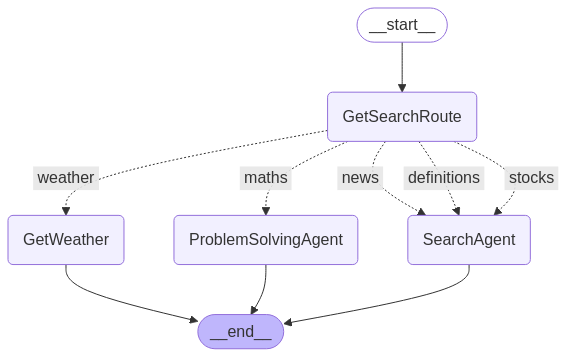

In [51]:
display(Image(research_assistant.get_graph().draw_mermaid_png()))

In [62]:
Markdown(research_assistant.invoke({"input_message":"trendings news in lagos"})["search_result"])

C:\Users\Eddy\anaconda3\envs\NLP_ENV\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


Here are some trending news updates in Lagos:

1. **Lagos Takes New Position on Africa Economy Ranking:** Lagos state is making strides in the economy ranking, with the Dangote Refinery pushing the GDP up. [Read more](https://www.legit.ng/business-economy/economy/1645101-lagos-takes-position-africa-economy-ranking-dangote-refinery-pushes-gdp-up/)

2. **Death toll in Lagos gas explosion hits five:** The death toll from a gas explosion on the Otedola Bridge along the Lagos-Ibadan Expressway has increased to five. [Read more](https://punchng.com/death-toll-in-lagos-gas-explosion-hits-five/)

3. **Court stops public viewing, streaming of 'Gangs of Lagos':** Justice Idowu Alakija of a Lagos High Court has ordered the halt of public viewing and streaming of the film, Gangs of Lagos. [Read more](https://thestreetjournal.org/court-stops-public-viewing-streaming-of-gangs-of-lagos/)